In [1]:
%load_ext autoreload
%autoreload 2

# Week 4 - Systematically Improving Your Rag Application

In this week, we'll look at how we can segment user queries into different categories so that we can prioritize different features based off the user satisfaction and query volume. We'll do so in three steps

1. First we'll show you how to generate a synthetic dataset of user queries based off Klarna's FAQ pages
2. Then we'll walk you through how to use unsupervised topic modelling to classify our queries and identify categories that we're performing poorly on to focus on
3. Then we'll take these insights and use them to build a classifier that can classify new queries using the categories we've identified over time, allowing us to monitor the performance of our application and where we're able to improve.

# Why Segment Queries?

One of the most difficult parts of developing a RAG application is knowing what features to prioritize. To do so, we can turn to query segmentation - where we group similar queries together using topic modelling so that we can understand the different kinds of queries that users are asking.

By doing so, we're able to avoid wasting time implementing features that only a small subset of users need. Our goal here is to identify two main query segments 

1. High User Volume, Low User Satisfcation
2. Low User Volume, High User Satisfcation

We want to quickly fix queries that match (1) and make sure that we spend some time thinking about queries that match (2). 

![](./assets/matrix.png)


## Klarna's Customer Service Chatbot

A while back, Klarna launched it's new customer service chatbot that was powered under the hood by OpenAI's GPT-4 model. This was used as a huge customer story by OpenAI which published a [writeup about it here](https://openai.com/index/klarna/)

In this notebook, we'll simulate the Klarna case study by generating synthetic queries that a user might have based off Klarna's FAQ. We've scrapped their FAQ pages ahead of time and cleaned it so that we have a list of questions with the following fields in the `./data/questions.jsonl` file. The relevant content for each question is stored in the `./data/md` folder under the same slug.

1. `question` : A question from their FAQ
2. `url` : The url slug that this question lives at
3. `parent_category` : The parent category that this question belongs to
4. `child_category` : The child category that this question belongs to

We want to generate a dataset of synthetic queries that are diverse and cover a wide range of topics. We'll do so in 3 steps

1. **Generate Initial Questions** : First, we'll generate some simple questions that are easy to answer using the FAQ
2. **Add Conditions For Diversity** : Then, we'll sample from these initial questions and generate more complex questions by adding more detail and context
3. **Evaluate Generated Questions**Finally, we'll make sure that they're diverse and cover a wide range of topics using metrics such as cosine similarity and average word count.

Throughout this process, we'll be using the `instructor` library to help us generate questions using structured outputs. This allows us to focus on the task at hand and not worry about ensuring that our outputs are valid. We've also provided a simple `label.py` streamlit app that you can use to manually label the questions as either high or low quality similar to Week 2's labelling exercise.

We recommend using this labelling app to help you filter out low quality and repeated generations at each step of the process - both when generating initial questions and when adding diversity to our data set.


# Creating Synthetic Queries

## Generating Initial Questions

We'll start by loading in the initial questions and content that we've scrapped from Klarna's FAQ pages. We want to use the chunk_id here as a key because it's easier to sample from and we can ensure that each chunk has a equally likely chance of being sampled.

We'll be loading in the 

1. `questions` : A list of questions that we've scrapped from Klarna's FAQ pages
2. `chunk_to_metadata` : A mapping from a chunk id to the metadata associated with that chunk
3. `chunk_to_content` : A mapping from a chunk id to the content associated with that chunk

We recommend using the `O1` model here to think through what questions might look like before generating any questions. For instance, we might expect questions to mostly be sent by customers when they face problems or encounter errors.

It's therefore unlikely for a customer to send a query like

- Could you tell me how I might avoid being phished with Klarna?
- I'd like to know more about the advantages and disadvantages of using Klarna

Instead queries would probably look like

- I just got an email telling me I've been charged by Klarna for a purchase I didn't make but it's not appearing in the app. What's happening?
- apple pay not working
- can't find klarna option on utility checkout

Most queries are not going to be nicely phrased as a coherent question with perfect grammer too and often times, customers will send messages that are not questions at all. Brainstorming through what some potential questions might look like can help us generate more realistic queries.

Ultimately, we need real user queries because there is a lot of variance in how people ask questions. So ideally you'll be doing this on a regular basis with your real user data, and then using those to generate more synthetic queries to systematically improve your RAG application. 

In order for us to quickly validate if a question can be answered, we want to make sure our model generates citations from the original context. Since our model might make some small formatting errors, we'll use the `fuzzywuzzy` library to make sure the citation matches a substring in the original context with at least 99% similarity.

We want these citations because we can use them when doing the manual curation of our dataset to see if the questions are grounded in the original context.

In [91]:
import json

# Load in questions
with open("./data/questions.jsonl", "r") as f:
    questions = [json.loads(line) for line in f]

chunk_to_metadata = {}
chunk_to_content = {}

# Map chunk_id to metadata
for question in questions:
    chunk_id = question["url"].split("/")[-2]
    chunk_to_metadata[chunk_id] = question

# Map chunk_id to content
for question in questions:
    chunk_id = question["url"].split("/")[-2]
    chunk_to_content[chunk_id] = open(f"./data/md/{chunk_id}.md", "r").read()

categories = set([question["parent_category"] for question in questions])
subcategories = set([question["child_category"] for question in questions])

category_to_chunk_id = {}
for question in questions:
    category = question["parent_category"]
    chunk_id = question["url"].split("/")[-2]
    if category not in category_to_chunk_id:
        category_to_chunk_id[category] = []
    category_to_chunk_id[category].append(chunk_id)


In [1]:
import instructor
from pydantic import BaseModel, field_validator, ValidationInfo
import random
from asyncio import Semaphore


class GeneratedQuestion(BaseModel):
    chain_of_thought: str
    citation: str
    question: str
    answer: str

    @field_validator("citation")
    def validate_citation(cls, v, info: ValidationInfo):
        from fuzzywuzzy import fuzz

        context = info.context["context"]

        if v not in context:
            # If exact match fails, try fuzzy matching against whole context
            ratio = fuzz.partial_ratio(v, context)
            if ratio < 0.99:
                raise ValueError(
                    f"Citation {v} not found in provided context (fuzzy match ratio: {ratio}%). Make sure to provide a citation that closely matches text from the context provided."
                )
        return v


class Question(BaseModel):
    question: str
    answer: str
    citation: str
    category: str
    subcategory: str

    @field_validator("category")
    def validate_category(cls, v):
        if v not in categories:
            raise ValueError(f"Category {v} not in categories")
        return v

    @field_validator("subcategory")
    def validate_subcategory(cls, v):
        if v not in subcategories:
            raise ValueError(f"Subcategory {v} not in subcategories")
        return v


/Users/ivanleo/Documents/coding/systematically-improving-rag/cohort_2/week4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ivanleo/Documents/coding/systematically-improving-rag/cohort_2/week4/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [95]:
async def generate_question(
    client: instructor.AsyncInstructor,
    context: str,
    category: str,
    subcategory: str,
    sem: Semaphore,
):
    async with sem:
        resp = await client.chat.completions.create(
            model="gpt-4o-min",
            messages=[
                {
                    "role": "user",
                    "content": "Generate a question and answer pair for the following context: {{context}}. Make sure that the answer has a citation that is directly provided from the context. This question should have a category of {{category}} and subcategory of {{subcategory}}",
                }
            ],
            response_model=GeneratedQuestion,
            context={
                "context": context,
                "category": category,
                "subcategory": subcategory,
            },
        )

        return Question(
            question=resp.question,
            answer=resp.answer,
            citation=resp.citation,
            category=category,
            subcategory=subcategory,
        )


In [12]:
from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio as asyncio
import os

client = instructor.from_openai(AsyncOpenAI())

# Define a semaphore here to limit the number of concurrent requests so that we don't get rate limited out of nowhere.
sem = Semaphore(10)
number = 5

coros = []
for _ in range(number):
    # Sample a random chunk, category and subcategory
    chosen_category = random.choice(list(category_to_chunk_id.keys()))
    chosen_chunk = random.choice(category_to_chunk_id[chosen_category])
    chosen_subcategory = chunk_to_metadata[chosen_chunk]["child_category"]
    coros.append(
        generate_question(
            client, chosen_chunk, chosen_category, chosen_subcategory, sem
        )
    )

resp = await asyncio.gather(*coros, total=number)

with open("./data/generated_questions.jsonl", "w") as f:
    for question in resp:
        f.write(json.dumps(question.model_dump()) + "\n")


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


## Adding Diversity

We want to have a diverse set of questions to do topic modelling with. If we use the same prompt over and over again, we'll end up getting the same kind of questions over and over. In that case, we'll only be wasting our tokens. 

In order to add more diversity, we want to vary our prompt. To do so, we'll vary the following parameters 

1. **Category** : We'll vary the specific category that the question belongs to
3. **Length**: We'll ask the model to generate questions that are short, medium or long in nature
4. **Intent** : We want to vary the intent by category and subcategory. This will allow us to generate questions that are more specific to certain types of queries
5. **Personas**: We'll condition the generation of questions on different persona types to help generate more diverse questions

We'l do so by configuring a `config.yml` file that's located in the root of our project. This will allow us to easily change the parameters and generate more diverse questions. We'll read in this file using a classmethod on the `QuestionGenerationConfig` class and then randomly sample from the different configuration values to generate our questions.

By doing so, we'll be able to generate a greater variety of questions by conditioning the generated question on these parameters. This is a simple way to add some diversity. If you'd like to go beyond this, some things that you can try are

1. **Generating complex personas** : You can use a language model to generate complex personas that have backstories and then generate questions based off those personas.
2. **Varying the kinds of questions generated** : You can condition the generation of questions on the kinds of questions you'd like to generate. For instance, you can condition on whether the question is about a specific product, a general question, ask for multi-hop questions that combine different chunks of information.

When doing these variations, we always want to define a simple Config object that contains the different parameters that we want to vary the questions by. This allows us to easily change the parameters and generate more diverse questions. 

In [84]:
import random
from dataclasses import dataclass
import yaml
from rich import print


@dataclass
class QuestionGenerationConfig:
    user_intent: str
    length: str
    persona: str
    category: str
    subcategory: str

    @classmethod
    def generate_config_for_category(cls, category: str):
        with open("./config.yml", "r") as file:
            config = yaml.load(file, Loader=yaml.FullLoader)

        length = random.choice(config["length"])
        persona = random.choice(config["persona"])
        subcategory = random.choice(list(config["customer_intents"][category].keys()))
        intent = random.choice(list(config["customer_intents"][category][subcategory]))
        return cls(
            user_intent=intent,
            category=category,
            subcategory=subcategory,
            length=length,
            persona=persona,
        )

    @classmethod
    def generate_config(cls):
        with open("./config.yml", "r") as file:
            config = yaml.load(file, Loader=yaml.FullLoader)

        length = random.choice(config["length"])
        persona = random.choice(config["persona"])

        category = random.choice(list(config["customer_intents"].keys()))
        subcategory = random.choice(list(config["customer_intents"][category].keys()))
        intent = random.choice(list(config["customer_intents"][category][subcategory]))
        return cls(
            length=length,
            persona=persona,
            user_intent=intent,
            category=category,
            subcategory=subcategory,
        )


config = QuestionGenerationConfig.generate_config_for_category("Refunds")
print(config)

QuestionGenerationConfig(
    user_intent='User wants to know how their payment schedule for Asos will be affected by the refund request',
    length='medium length query that has minimal detail',
    persona="a college student that's using the product to buy their college equipment or other necessities",
    category='Refunds',
    subcategory='Manage_Refunds'
)

In [104]:
import instructor


async def generate_question_with_config(
    client: instructor.AsyncInstructor,
    config: QuestionGenerationConfig,
    context:str,
    examples: list[Question],
    sem: Semaphore,
):
    async with sem:
        resp = await client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": """
                    Generate a hypothetical message that a customer might send to a customer support chatbot for Klarna. 

                    Please observe the following rules
                    - Customers will ask questions when they face issues so make up potential purchases and time periods that these issues are occuring within. For instance if a customer is asking about their refund for a sports brand, choose a random item that that brand might sell and invent a fictional price for that item.
                    - Provide an exact citation from the context provided that the answer can be generated from. This should be copied entirely from the context given without any editing. 
                    - Make sure that you respect the length, tone, persona and intent of the question that you're going to be given. This is extremely important
                    - If you're asked to generate a short question, make sure that it's concise and to the point.
                    - Customers will not know internal terminology of Klarna well so instead of saying something like Klarna balance they might say oh I topped up the balance with my X debit and then ... 
                    - If the context for instance talks about returns over a 14 day period, queries might come from customers that are on day 4, 7 etc and will definitely not know that returns take up to 14 days.                  
                    - Try to avoid messages that use the words how what when why etc and phrase it as a message someone might send when they're really frustrated.

                    Here is some context that you should refer to generate the question with
                    <context>
                    {{context}}
                    </context>

                    Here are some sample questions that have been asked before
                    {% for question in examples %}
                    {{ loop.index }}: {{ question.question }}
                    {% endfor %}

                    Here is some specification for what the question should look like
                    - Length of customer message : {{config.length}}
                    - User intent : {{config.user_intent}}
                    - Persona of the customer : {{config.persona}}  
                    - Category of the question : {{config.category}}
                    - Subcategory of the question : {{config.subcategory}}

                    Make sure that your generated question adheres to the above configuration and that it's different from the examples provided. 
                    """,
                }
            ],
            response_model=GeneratedQuestion,
            context={
                "config": config,
                "context": context,
                "examples": examples,
            },
        )

        return Question(
            question=resp.question,
            answer=resp.answer,
            citation=resp.citation,
            category=config.category,
            subcategory=config.subcategory,
        )

In [131]:
import json
from openai import AsyncOpenAI
from anthropic import AsyncAnthropic
from tqdm.asyncio import tqdm_asyncio as asyncio
import instructor

with open("./data/cleaned.jsonl", "r") as f:
    saved_questions = [Question(**json.loads(line)) for line in f]

client = instructor.from_openai(AsyncOpenAI())


sem = Semaphore(20)
number = 20

coros = []
for _ in range(number):
    config = QuestionGenerationConfig.generate_config()

    # We get all the chunks that belong to the category
    valid_chunk_ids = [
        chunk_id
        for chunk_id in chunk_to_metadata.keys()
        if chunk_to_metadata[chunk_id]["parent_category"] == config.category
    ]
    valid_chunks = [chunk_to_content[chunk_id] for chunk_id in valid_chunk_ids]

    valid_examples = [q.question for q in saved_questions if q.category == config.category]
    examples = random.sample(valid_examples, random.randint(0, max(len(valid_examples),9)))

    coros.append(
        generate_question_with_config(
            client=client,
            context='\n'.join(valid_chunks),
            examples=examples,
            config=config,
            sem=sem,
        )
    )

resp = await asyncio.gather(*coros, total=number)
with open("./data/synthetic_questions.jsonl", "w") as f:
    for question in resp:
        f.write(json.dumps(question.model_dump()) + "\n")


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


In [132]:
with open("./data/cleaned.jsonl", "r") as f:
    questions = [Question(**json.loads(line)) for line in f]

counts = {}
for question in questions:
    counts[question.category] = counts.get(question.category, 0) + 1

counts, len(questions)


({'Account & settings': 34,
  'Fraud & security': 21,
  'Products & services': 44,
  'Declined purchase': 12,
  'Delivery & returns': 15,
  'Payments': 19,
  'Refunds': 56},
 201)

## Evaluating Generated Questions

We want to make sure that our questions are diverse and cover a wide range of topics. 

To do so, we'll evaluate our questions using two main methods

1. Cosine Similiarity: We want to make sure there's a good spread of cosine similarity scores in each category. If a category has a low variance, it means that there are some questions that are very similar to each other and we might want to generate more diverse questions.
2. Word Length: We also want to make sure that the questions have a good spread of word lengths. If a category has a low variance, it means that there are some questions that are very short or very long and we might want to generate more diverse questions.

Ultimately depending on your specific use case, you might want to evaluate your generated questions using a combination of these methods. The main goal here is to just get a sense for how diverse your generated questions are.

In [145]:
from asyncio import Semaphore
from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio as asyncio


async def generate_embedding_for_question(
    client: AsyncOpenAI, question: dict[str, str], sem: Semaphore
):
    async with sem:
        resp = await client.embeddings.create(
            model="text-embedding-3-small",
            input=question["question"],
        )
        embedding = resp.data[0].embedding
        return {
            "question": question["question"],
            "embedding": embedding,
            "category": question["category"],
            "subcategory": question["subcategory"],
        }


client = instructor.from_openai(AsyncOpenAI())

questions = []
with open("./data/cleaned.jsonl", "r") as f:
    for line in f:
        item = json.loads(line)
        questions.append(
            {
                "question": item["question"],
                "category": item["category"],
                "subcategory": item["subcategory"],
            }
        )

sem = Semaphore(20)
coros = [generate_embedding_for_question(client, q, sem) for q in questions]
resp = await asyncio.gather(*coros, total=len(questions))

100%|█████████▉| 200/201 [00:16<00:00, 31.51it/s]

In [134]:
# Convert embeddings to numpy array for similarity calculation
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# Extract embeddings and organize by category
questions_by_category = {}
embeddings_by_category = {}

for item in resp:
    category = item["category"]
    if category not in questions_by_category:
        questions_by_category[category] = []
        embeddings_by_category[category] = []

    questions_by_category[category].append(item["question"])
    embeddings_by_category[category].append(item["embedding"])

# Calculate pairwise similarities within each category
category_similarities = {}
for category in questions_by_category:
    embeddings = np.array(embeddings_by_category[category])
    similarities = cosine_similarity(embeddings)

    # Get upper triangle values (excluding diagonal)
    mask = np.triu_indices(len(similarities), k=1)
    upper_tri_similarities = similarities[mask]

    category_similarities[category] = {
        "mean": float(np.mean(upper_tri_similarities)),
        "std": float(np.std(upper_tri_similarities)),
        "min": float(np.min(upper_tri_similarities)),
        "max": float(np.max(upper_tri_similarities)),
        "num_questions": len(embeddings),
    }


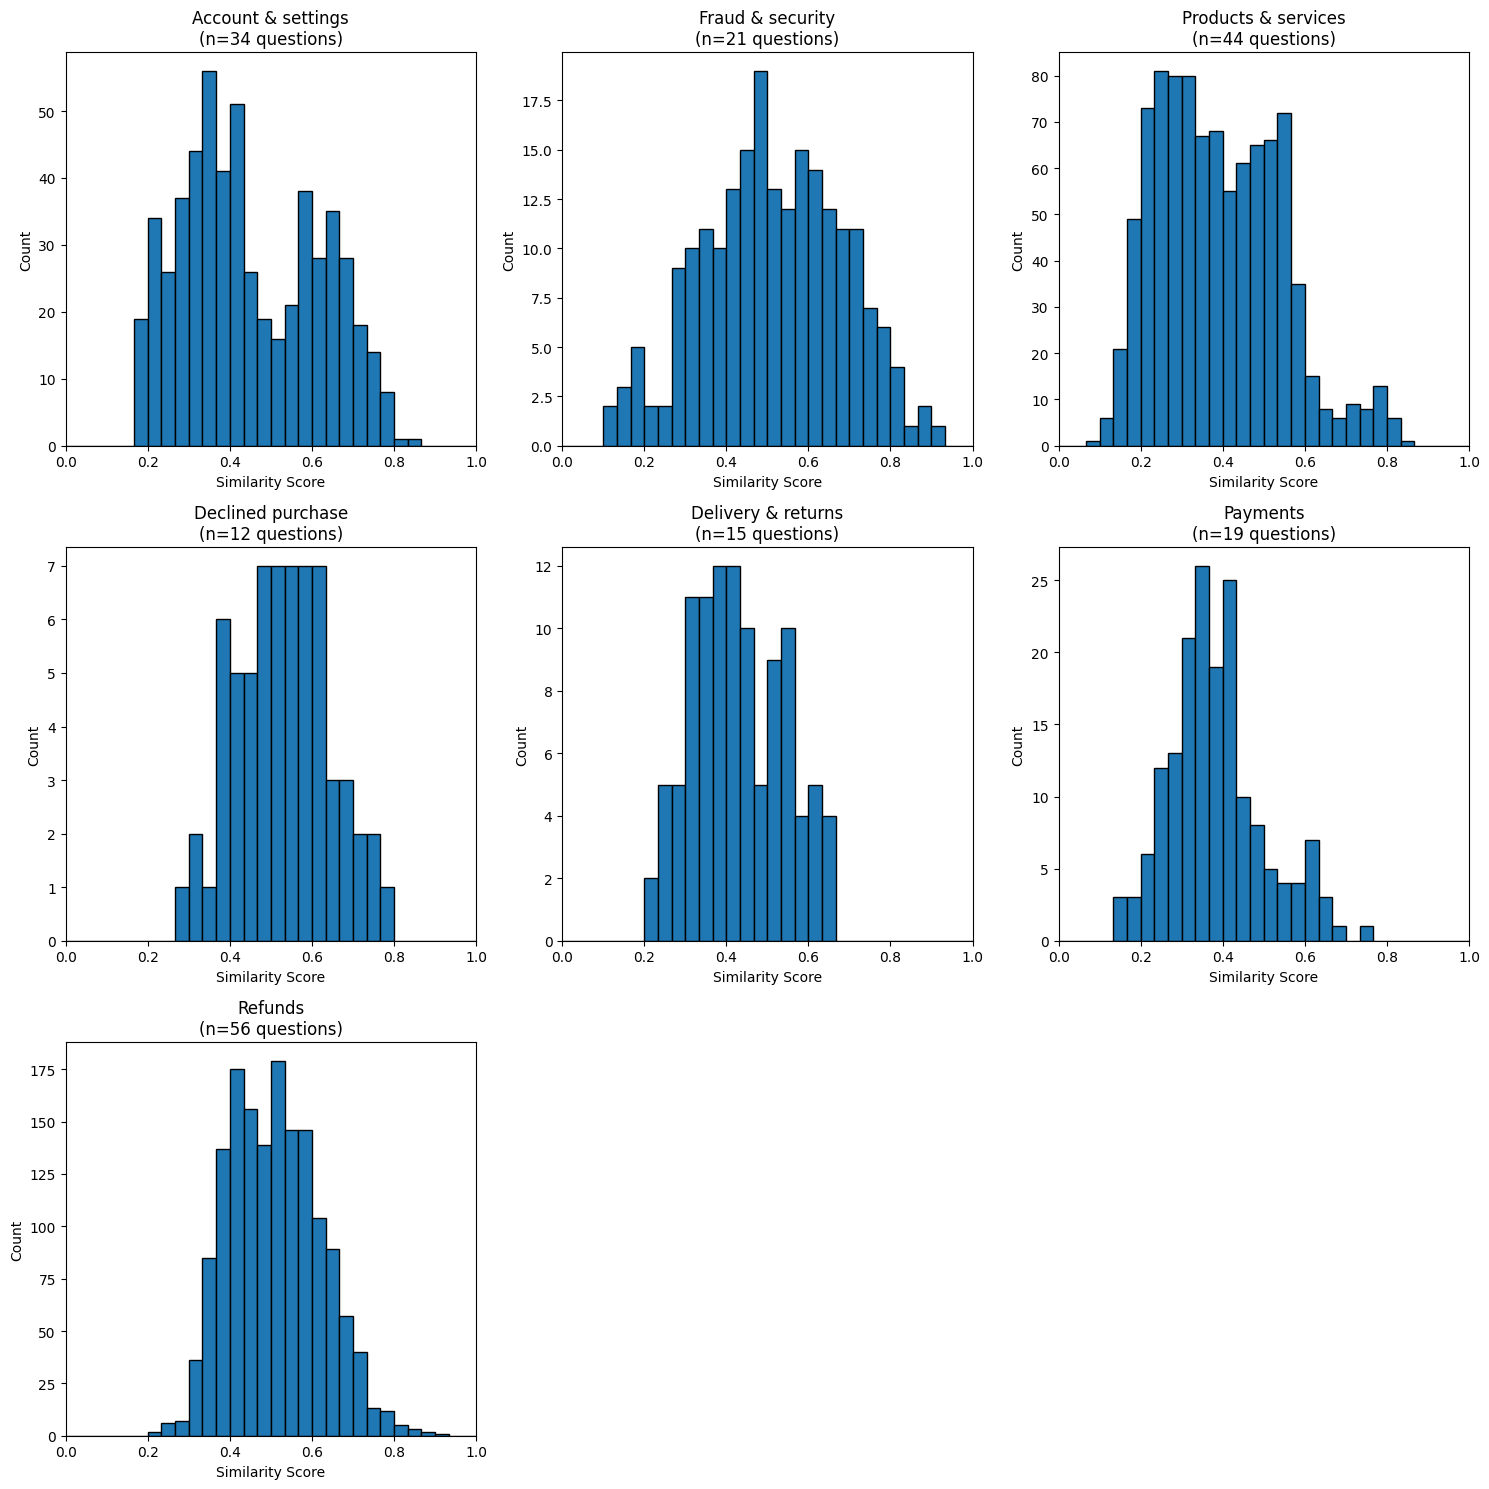

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Get categories in a consistent order
categories = list(category_similarities.keys())

# Calculate number of rows needed (2 categories per row)
n_categories = len(categories)
n_rows = (n_categories + 2) // 3  # Round up division

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create histogram for each category
for i, category in enumerate(categories):
    embeddings = np.array(embeddings_by_category[category])
    similarities = cosine_similarity(embeddings)

    # Get upper triangle values (excluding diagonal)
    mask = np.triu_indices(len(similarities), k=1)
    similarities = similarities[mask]

    # Plot histogram
    axes[i].hist(similarities, bins=30, edgecolor="black", range=(0, 1))
    axes[i].set_title(f"{category}\n(n={len(embeddings)} questions)")
    axes[i].set_xlabel("Similarity Score")
    axes[i].set_ylabel("Count")
    axes[i].set_xlim(0, 1)

# Remove any empty subplots
for i in range(n_categories, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


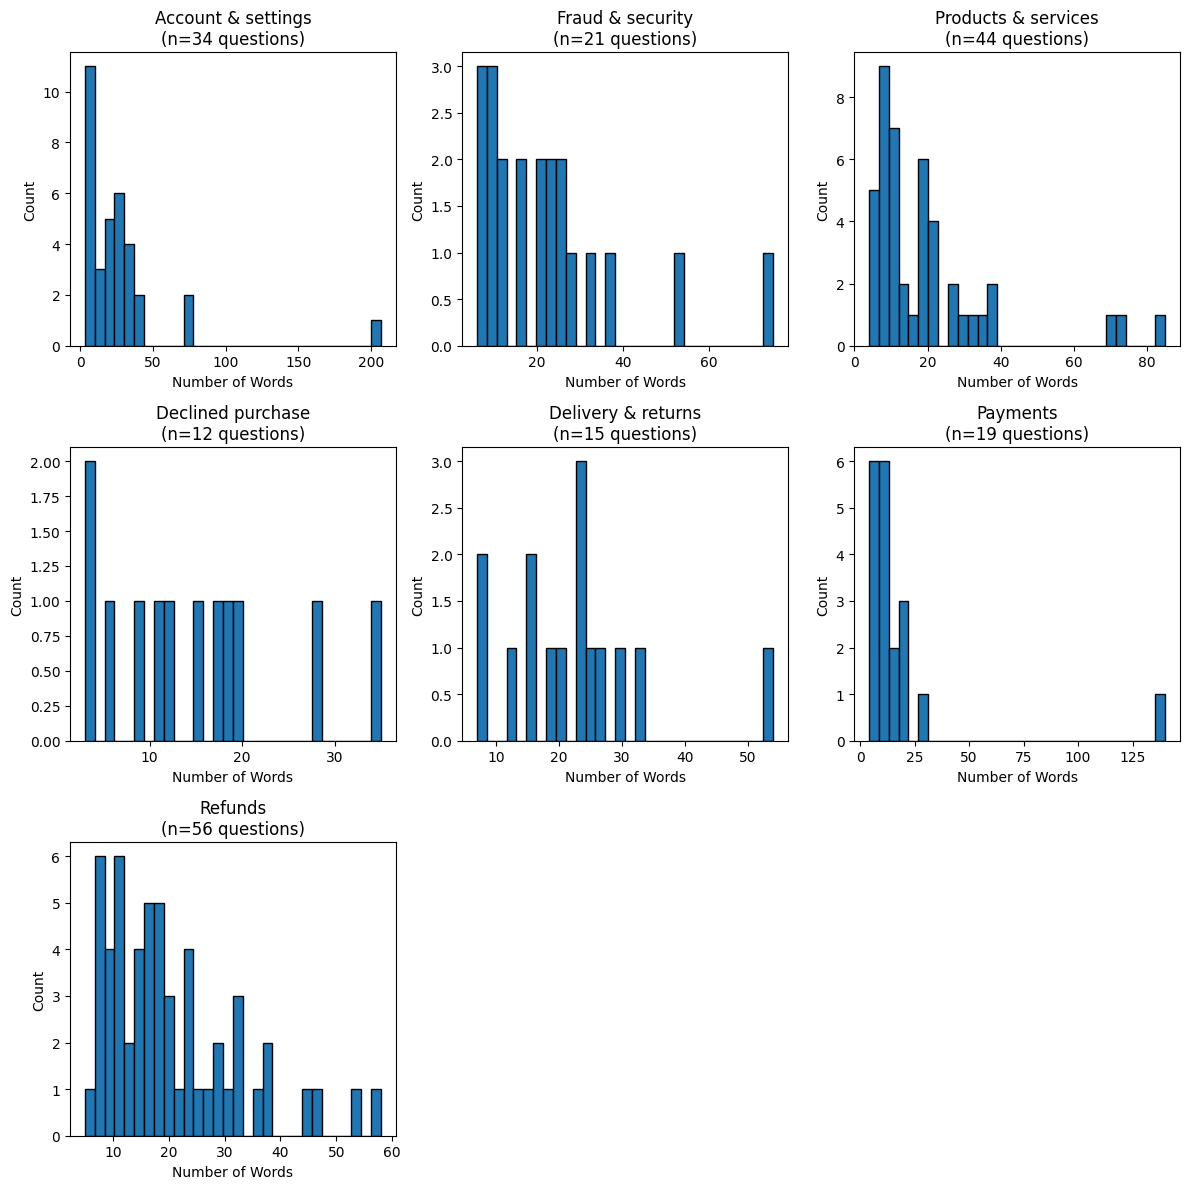

In [150]:
# Get word lengths for all questions by category
words_by_category = {}
for category in categories:
    filtered_questions = [q for q in questions if q["category"] == category]
    words = [len(q["question"].split()) for q in filtered_questions]
    words_by_category[category] = words

# Create subplots for each category
n_categories = len(categories)
n_rows = (n_categories + 2) // 3  # Round up division
fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Create histogram for each category
for i, category in enumerate(categories):
    axes[i].hist(words_by_category[category], bins=30, edgecolor='black')
    axes[i].set_title(f"{category}\n(n={len(words_by_category[category])} questions)")
    axes[i].set_xlabel('Number of Words')
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for i in range(n_categories, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Conclusion

From the charts above, we can see that the questions are semantically diverse across different topics and have varying word lengths. This is a good sign because it means that we're covering a wide range of potential queries that users might generate and we're not just getting a lot of very short or very long questions.

In the next notebook, we'll use these synthetic questions that we've generated to perform topic modelling to see if we can identify categories of queries that users are asking which we might need to prioritize. This is important because we want to be able to categorize and prioritize different types of queries so that we can focus on the most important ones that have a high query volume and potentially low user satisfaction.